In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

In [30]:
location=[1,2]
max_car_num=20
reward_rent_onecar=10
cost_move_onecar=2
move_1day_max_car_num=5
requests_avg=[3,4]
returns_avg=[3,2]
gamma=0.9
theta=0.0001
action=np.arange(-move_1day_max_car_num,move_1day_max_car_num+1)
value = np.zeros((max_car_num+1, max_car_num+1))    
policy = np.zeros(value.shape, dtype=int)
poisson_visited = dict()

In [31]:
def action_choice_prob(n,lamda):
    visited_prob=n*20+lamda
    if visited_prob not in poisson_visited:
        poisson_visited[visited_prob]=poisson.pmf(n,lamda)
    return poisson_visited[visited_prob]

In [32]:
# def state_value_compute(act,state,state_value):
#     state_value_update=0.0
#     state_value_update-=cost_move_onecar*abs(act)
#     for i in range(max_car_num+1):
#         for j in range(max_car_num+1):
#             request_prob=action_choice_prob(i,requests_avg[0])*action_choice_prob(j,requests_avg[1])
#             curr_1_car_num=min(state[0]-act,max_car_num)
#             curr_2_car_num=min(state[1]+act,max_car_num)
#             rent_from1_available_car_num=min(curr_1_car_num,i)
#             rent_from2_available_car_num=min(curr_2_car_num,j)
#             curr_reward=(rent_from1_available_car_num+rent_from2_available_car_num)*reward_rent_onecar
#             curr_1_car_num-=rent_from1_available_car_num
#             curr_2_car_num-=rent_from2_available_car_num
#             for m in range(max_car_num+1):
#                 for n in range(max_car_num+1):
#                     return_prob=action_choice_prob(m,returns_avg[0])*action_choice_prob(n,returns_avg[1])
#                     curr_1_car_num_follow=min(curr_1_car_num+m,max_car_num)
#                     curr_2_car_num_follow=min(curr_2_car_num+n,max_car_num)
#                     prob_transition=return_prob*request_prob
#                     state_value_update+=prob_transition*(curr_reward+gamma*state_value[curr_1_car_num_follow,curr_2_car_num_follow])
#     return state_value_update

In [33]:
def state_value_compute(act,state,state_value,return_cars):
    state_value_update=0.0
    state_value_update-=cost_move_onecar*abs(act)
    for i in range(max_car_num+1):
        for j in range(max_car_num+1):
            request_prob=action_choice_prob(i,requests_avg[0])*action_choice_prob(j,requests_avg[1])
            curr_1_car_num=min(state[0]-act,max_car_num)
            curr_2_car_num=min(state[1]+act,max_car_num)
            rent_from1_available_car_num=min(curr_1_car_num,i)
            rent_from2_available_car_num=min(curr_2_car_num,j)
            curr_reward=(rent_from1_available_car_num+rent_from2_available_car_num)*reward_rent_onecar
            curr_1_car_num-=rent_from1_available_car_num
            curr_2_car_num-=rent_from2_available_car_num
            if return_cars:
                curr_1_car_num_follow=min(curr_1_car_num+returns_avg[0],max_car_num)
                curr_2_car_num_follow=min(curr_2_car_num+returns_avg[1],max_car_num)
                state_value_update+=request_prob*(curr_reward+gamma*state_value[curr_1_car_num_follow,curr_2_car_num_follow])
            else:
                for m in range(max_car_num+1):
                    for n in range(max_car_num+1):
                        return_prob=action_choice_prob(m,returns_avg[0])*action_choice_prob(n,returns_avg[1])
                        curr_1_car_num_follow=min(curr_1_car_num+m,max_car_num)
                        curr_2_car_num_follow=min(curr_2_car_num+n,max_car_num)
                        prob_transition=return_prob*request_prob
                        state_value_update+=prob_transition*(curr_reward+gamma*state_value[curr_1_car_num_follow,curr_2_car_num_follow])
    return state_value_update

In [34]:
def policy_evaluation():
    while True:
        pre_value=value.copy()
        for i in range(max_car_num+1):
            for j in range(max_car_num+1):
                state_value_update=state_value_compute(policy[i,j],[i,j],value,return_cars=True)
                value[i,j]=state_value_update
        delta=abs(pre_value-value).max()
        print(f'delta: {delta}')
        if delta<theta:
            break
    return value

In [35]:
def policy_improvement():
    policy_stable=True
    for i in range(max_car_num+1):
        for j in range(max_car_num+1):
            old_action=policy[i,j]
            action_update=[]
            for k in action:
                if i>=k and -j<=k :
                    action_update.append(state_value_compute(k,[i,j],value,return_cars=True))
                else:
                    action_update.append(-np.inf)
            curr_best_action=action[np.argmax(action_update)]
            policy[i,j]=curr_best_action
            if old_action!=curr_best_action and policy_stable:
                policy_stable=False
    return policy_stable,policy
    

In [36]:
def value_evalution():
    iter=0
    while True:
        pre_value=value.copy()
        for i in range(max_car_num+1):
            for j in range(max_car_num+1):
                value_update=[]
                for k in action:
                    if i>=k and -j<=k :
                        value_update.append(state_value_compute(k,[i,j],value,return_cars=True))
                    else:
                        value_update.append(-np.inf)
                value_best=np.max(value_update)
                value[i,j]=value_best
        delta=abs(pre_value-value).max()
        print(f'delta: {delta}')
        iter+=1
        if delta<theta:
            break
    return value

In [37]:
def policy_from_optimal_value():
    for i in range(max_car_num+1):
        for j in range(max_car_num+1):
            value_update=[]
            for k in action:
                if i>=k and -j<=k :
                    value_update.append(state_value_compute(k,[i,j],value,return_cars=True))
                else:
                    value_update.append(-np.inf)
            policy[i,j]=action[np.argmax(np.round(value_update,5))]
    return policy

In [38]:
def figure_value(value, policy):
    fig = plt.figure(figsize=(20, 20)) 
    ax = fig.add_subplot(121)    
    ax.matshow(policy, cmap=plt.cm.bwr, vmin=-move_1day_max_car_num, vmax=move_1day_max_car_num)
    ax.set_xticks(range(max_car_num+1))
    ax.set_yticks(range(max_car_num+1))
    ax.invert_yaxis()
    ax.set_xlabel("Cars at second location")
    ax.set_ylabel("Cars at first location")
    ax.set_title(r'$\pi_{value}$', fontsize=20)
    for x in range(max_car_num+1):
        for y in range(max_car_num+1):
            ax.text(x=x, y=y, s=int(policy.T[x, y]), va='center', ha='center', fontsize=10)
    
    y, x = np.meshgrid(range(max_car_num+1), range(max_car_num+1))
    ax = fig.add_subplot(122, projection='3d')   
    ax.scatter3D(y, x, value.T)
    ax.set_xlim3d(0, max_car_num)
    ax.set_ylim3d(0, max_car_num)
    ax.set_xlabel("Cars at second location")
    ax.set_ylabel("Cars at first location")
    ax.set_title('value for ' + r'$\pi_{value}$', fontsize=20)
    plt.savefig('value.png',bbox_inches='tight')

In [39]:
def figure_policy(value, policy, iteration):
    fig = plt.figure(figsize=(20, 20)) 
    ax = fig.add_subplot(121)    
    ax.matshow(policy, cmap=plt.cm.bwr, vmin=-move_1day_max_car_num, vmax=move_1day_max_car_num)
    ax.set_xticks(range(max_car_num+1))
    ax.set_yticks(range(max_car_num+1))
    ax.invert_yaxis()
    ax.set_xlabel("Cars at second location")
    ax.set_ylabel("Cars at first location")
    ax.set_title(r'$\pi_{}$'.format(iteration), fontsize=20)
    for x in range(max_car_num+1):
        for y in range(max_car_num+1):
            ax.text(x=x, y=y, s=int(policy.T[x, y]), va='center', ha='center', fontsize=10)
    
    y, x = np.meshgrid(range(max_car_num+1), range(max_car_num+1))
    ax = fig.add_subplot(122, projection='3d')   
    ax.scatter3D(y, x, value.T)
    ax.set_xlim3d(0, max_car_num)
    ax.set_ylim3d(0, max_car_num)
    ax.set_xlabel("Cars at second location")
    ax.set_ylabel("Cars at first location")
    ax.set_title('value for ' + r'$\pi_{}$'.format(iteration), fontsize=20)
    plt.savefig(f'{iteration}_policy_T.png',bbox_inches='tight')

In [40]:
def policy_iteration():
    iter=0
    while True:
        value_update=policy_evaluation()
        stable,policy_update=policy_improvement()
        iter+=1
        print('iteration: {}, policy stable {}'.format(iter, stable))
        figure_policy(value_update,policy_update,iter)
        if stable==True:
            break

In [41]:
def value_interation():
    value_update=value_evalution()
    print('value:')
    print(value_update)
    policy_update=policy_from_optimal_value()
    print('policy:')
    print(policy_update)
    figure_value(value_update,policy_update)

delta: 365.1085505491228
delta: 152.36397043724043
delta: 95.08114396269548
delta: 64.44244130529268
delta: 48.222703892166834
delta: 38.31639248257375
delta: 30.295732939495423
delta: 23.973591474266357
delta: 19.11915869474774
delta: 16.071479463065884
delta: 13.55125653592603
delta: 11.397162882810733
delta: 9.606033455171087
delta: 8.1035882557602
delta: 6.872440024768821
delta: 5.839997120136616
delta: 4.964631351268508
delta: 4.220485769092932
delta: 3.587707242375643
delta: 3.0496940463886517
delta: 2.5923091365622213
delta: 2.2034978995871484
delta: 1.8730137551148687
delta: 1.5921187051248467
delta: 1.3533714471143412
delta: 1.1504380467892474
delta: 0.9779394073668755
delta: 0.8313079137712407
delta: 0.7066633186154263
delta: 0.6007081985043214
delta: 0.510639951812891
delta: 0.43409204178999516
delta: 0.36911650452270806
delta: 0.3139655014886671
delta: 0.26709601090294655
delta: 0.2272369301723529
delta: 0.19333028453047518
delta: 0.16448429775527984
delta: 0.13994278048136

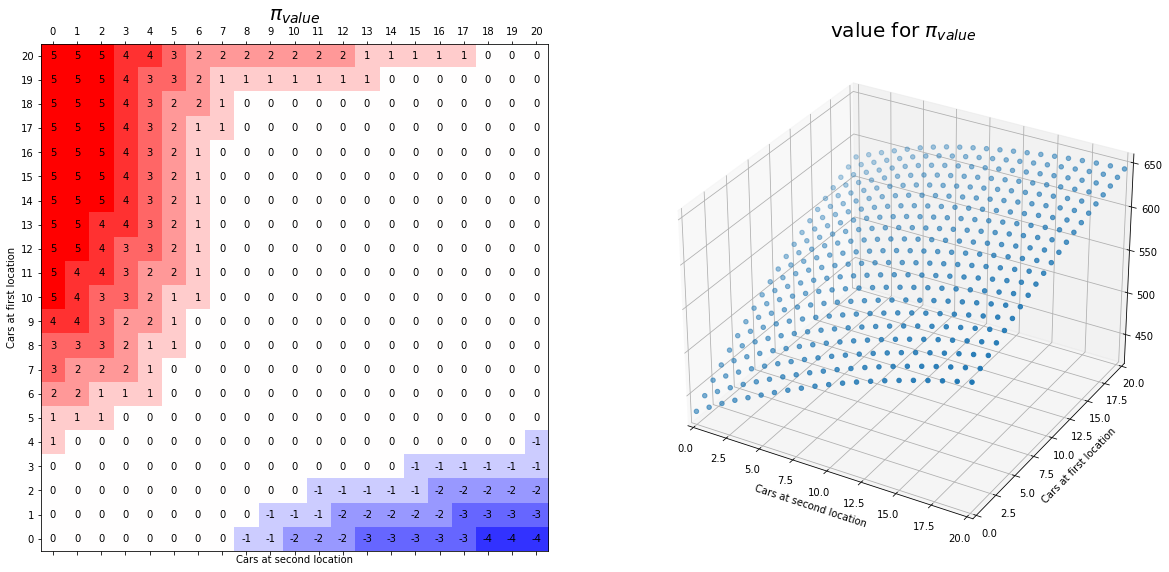

In [42]:
if __name__ == '__main__':
    # policy_iteration()
    value_interation()